In [1]:
#!/usr/bin/env python
import os, glob
from nilearn import image
from nilearn import plotting
import numpy as np
import pandas as pd

In [2]:
def utils_extract_schaefer2018(nifti_fname_dict):
    # parameters
    # ==========
    #   nifti_fname: 
    # result
    # ======
    # run them through nifti masker
    import argparse
    import numpy as np
    import os, glob
    import pandas as pd
    from nilearn import image
    from nilearn.maskers import NiftiLabelsMasker
    from nilearn import datasets

    singletrial_dir = nifti_fname_dict['singletrial_dir']; sub = nifti_fname_dict['sub'];
    ses = nifti_fname_dict['ses']; run = nifti_fname_dict['run']; runtype = nifti_fname_dict['runtype']; event = nifti_fname_dict['event'];

    img_flist = glob.glob(os.path.join(singletrial_dir, sub, f'{sub}_{ses}_{run}_{runtype}_event-{event}_trial-*.nii.gz'))
    img_flist = sorted(img_flist)

    stacked_singletrial = image.concat_imgs(sorted(img_flist))

    dataset = datasets.fetch_atlas_schaefer_2018()
    atlas_filename = dataset.maps
    # labels = dataset.labels
    labels = np.insert(dataset.labels, 0, 'Background')
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                            memory='nilearn_cache', verbose=5)
    time_series = masker.fit_transform(stacked_singletrial) # (trials, parcels)
    labels_utfstring = [x.decode('utf-8')  for x in labels[1:] ]
    singletrial_vstack_beta = pd.DataFrame(time_series, columns = labels_utfstring)
    flist_basename = [os.path.basename(m) for m in sorted(img_flist)]
    singletrial_vstack_beta.insert(0, 'singletrial_fname', flist_basename)
    return singletrial_vstack_beta

In [6]:
# 1. load nifti image
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub = 'sub-0030'; ses = 'ses-01'; run = '*'; runtype = 'pain'; event = 'stimulus'
img_flist = glob.glob(os.path.join(singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-{event}*.nii.gz'))
print(img_flist[0:10])
img_flist = sorted(img_flist)
stacked_singletrial = image.concat_imgs(sorted(img_flist))


['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-stimulus_trial-003_cuetype-high_stimintensity-low.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-011_cuetype-high_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-010_cuetype-low_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-sti

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


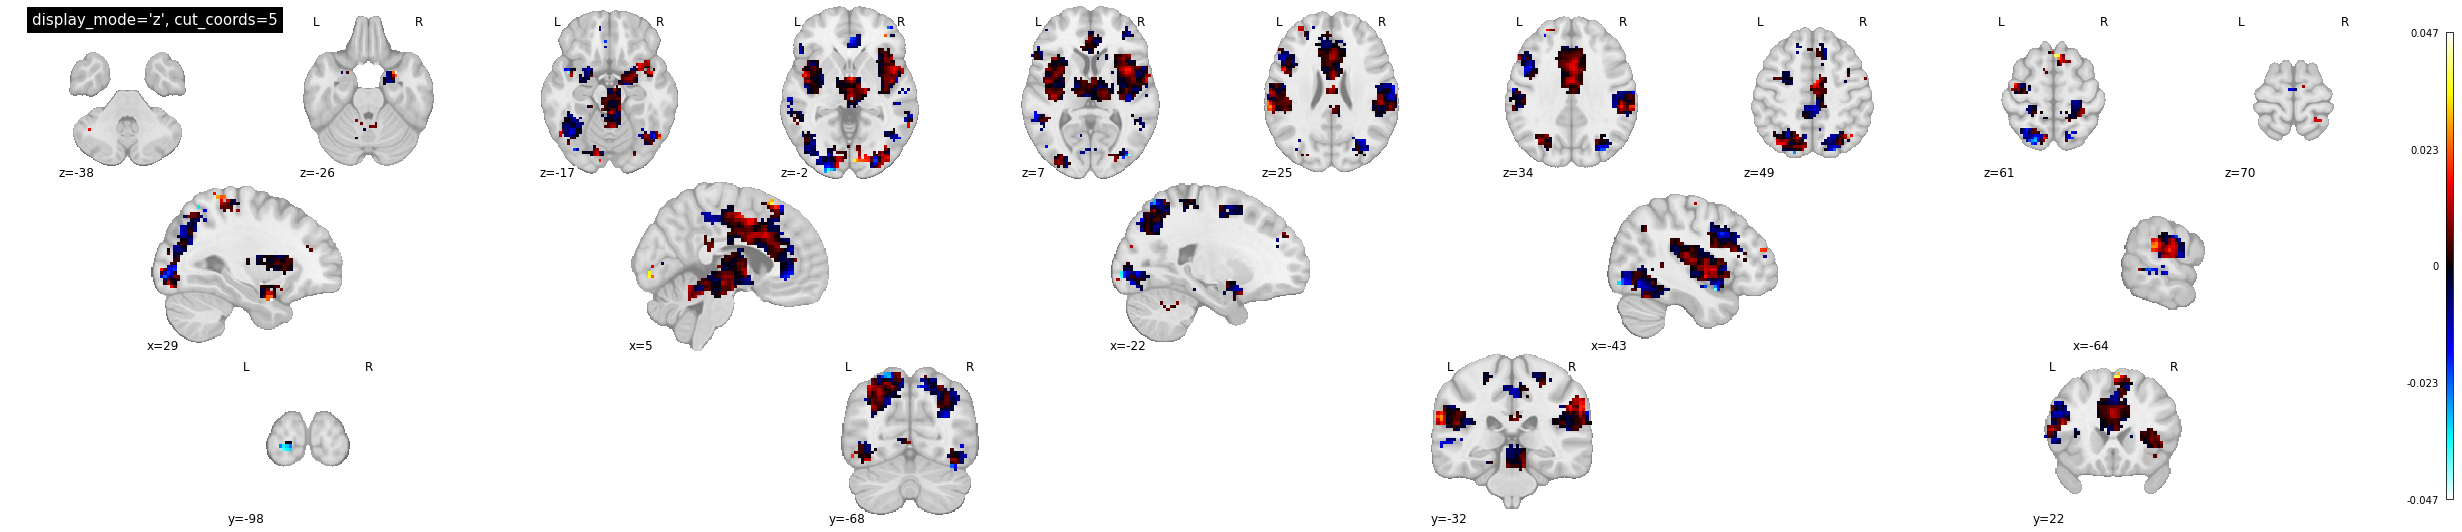

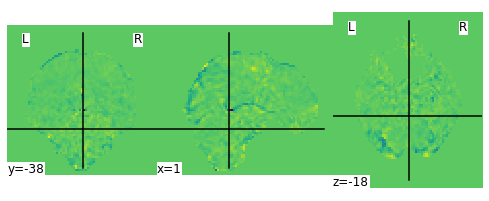

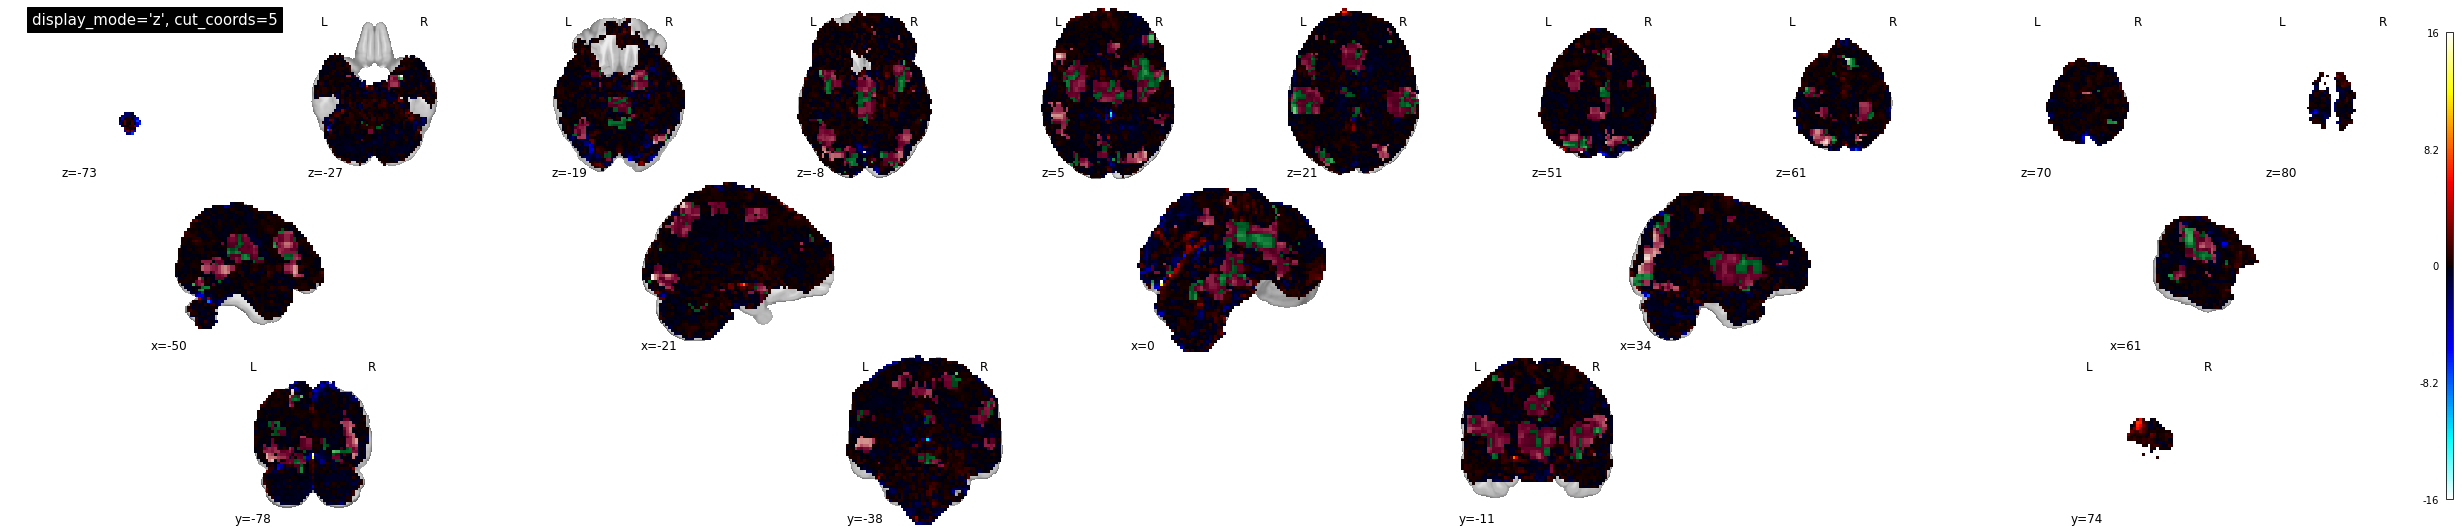

In [7]:
# 3. resample space
nps = '/Users/h/Documents/MATLAB/MasksPrivate/Masks_private/2013_Wager_NEJM_NPS/weights_NSF_grouppred_cvpcr.nii.gz'
nps_img = image.load_img(nps)

plotting.plot_stat_map(nps_img,display_mode='mosaic',
                       cut_coords=(5, 4, 10),
                       title="display_mode='z', cut_coords=5")
plotting.plot_img(image.mean_img(stacked_singletrial))
# %% resample space
resampled_nps = image.resample_img(nps_img, 
                                   target_affine = stacked_singletrial.affine, 
                                   target_shape = stacked_singletrial.shape[0:3],
                                   interpolation = 'nearest')

# %% check: plot resampled
display = plotting.plot_stat_map(image.mean_img(stacked_singletrial),display_mode='mosaic',
                       cut_coords=(5, 4, 10),
                       title="display_mode='z', cut_coords=5")
display.add_overlay(resampled_nps,cmap=plotting.cm.purple_green)



In [9]:
# %% apply nps
nps_array = image.get_data(resampled_nps)
singletrial_array = image.get_data(stacked_singletrial)
len_singletrialstack = singletrial_array.shape[-1]
vectorize_singletrial = singletrial_array.reshape(np.prod(list(singletrial_array.shape[0:3])),len_singletrialstack )
nps_extract = np.dot(nps_array.reshape(-1), vectorize_singletrial)
nps_df = pd.DataFrame({'singletrial_fname': [os.path.basename(basename) for basename in img_flist], 'nps': nps_extract})
nps_df.head()

,singletrial_fname,nps
0,sub-0030_ses-01_run-03_runtype-pain_event-stim...,14.279780
1,sub-0030_ses-01_run-03_runtype-pain_event-stim...,2.128011
2,sub-0030_ses-01_run-03_runtype-pain_event-stim...,5.970292
3,sub-0030_ses-01_run-03_runtype-pain_event-stim...,2.582800
4,sub-0030_ses-01_run-03_runtype-pain_event-stim...,4.071396
